## Libraries 

In [34]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import csv
import pandas as pd
from matplotlib.pyplot import imshow
import os

%matplotlib inline



In [35]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K


In [36]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

## Model

In [32]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes, finalAct="softmax"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))
		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# use a *softmax* activation for single-label classification
		# and *sigmoid* activation for multi-label classification
		model.add(Dense(classes))
		model.add(Activation(finalAct))

		# return the constructed network architecture
		return model

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 150, 150)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_3/MaxPool' (op: 'MaxPool') with input shapes: [?,1,148,32].

## Model

## Data Generation

In [7]:
def generateData(femurLengthMean,femurLengthSD,femurNeckAngleMean,femurNeckAngleSD,tibioFemuralAngleMean,tibioFemuralAngleSD):
    # create normally distributed Femur
    # a - femurLength
    # b - femurNeckLength
    # c - axisLength
    # A - hipAngle
    # B - tibioFemuralAngle
    # C - femurNeckAngle
        
    #femurLengthMean, femurLengthSD = 18,1.3 # mean and standard deviation
    #femurNeckAngleMean,femurNeckAngleSD=130,1.5
    #tibioFemuralAngleMean,tibioFemuralAngleSD=5,1
        
    femurLength = np.random.normal(femurLengthMean, femurLengthSD, 1)
    femurNeckAngle=np.random.normal(femurNeckAngleMean, femurNeckAngleSD, 1)
    tibioFemuralAngle=np.random.normal(tibioFemuralAngleMean, tibioFemuralAngleSD, 1)
    hipAngle=180-femurNeckAngle-tibioFemuralAngle
    femurNeckLength= ((math.sin(math.pi*tibioFemuralAngle/180))*femurLength ) / math.sin(math.pi*hipAngle/180)
    axisLength= ((math.sin(math.pi*femurNeckAngle/180))*femurNeckLength ) / math.sin(math.pi*tibioFemuralAngle/180)
        
        
    points=(0,0),(0,np.asscalar(axisLength)),(np.asscalar(-math.cos( math.pi*(90-hipAngle)/180 )*femurNeckLength),np.asscalar(axisLength-math.sin( math.pi*(90-hipAngle)/180 )*femurNeckLength))
    x=[points[0][0],points[1][0],points[2][0]]
    y=[points[0][1],points[1][1],points[2][1]]    
    return x,y,np.asscalar(tibioFemuralAngle),np.asscalar(femurLength),np.asscalar(femurNeckAngle)
    
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')
def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width,height,width*height

def generateImages(startAt,k):
    imageList=[]
    imageLabel=[]
    imageSupporting={}
    for i in range(startAt,k):
        x,y,tibioFemuralAngle,femurLength,femurNeckAngle = generateData(18,1.3,130,1.5,5,1)
        fig=plt.figure()
        plt.axis('equal')
        fig.set_size_inches(25, 25)
        plt.xlim((math.floor(np.min(x)),math.ceil(np.max(x))))
        plt.ylim((math.floor(np.min(y)), math.ceil(np.max(y))))
        plt.axis('off')
        plt.plot(x,y, 'ro')
        plt.plot([0,10],[1,1])
        connectpoints(x,y,0,2)
        connectpoints(x,y,2,1)
        connectpoints(x,y,2,2)

        fname=path+'/TFA'+str(i)+'.jpg'
        fig.savefig(fname, dpi=132,bbox_inches = 'tight', pad_inches = 0)
        #print(get_num_pixels(fname))
        image = cv2.imread (fname)
        imageList.append (image)
        #imagex=cv2.resize(np.float32(imageList[i]),(1200,1200))
        #cv2.imwrite(fname, imagex)
        imageLabel.append(int(tibioFemuralAngle))
        imageSupporting[fname]=tibioFemuralAngle,femurLength,femurNeckAngle
        #print(x,y,tibioFemuralAngle)
        plt.close(fig)
    return imageList,imageLabel,imageSupporting



In [8]:
path=r'C:\Users\aliad\Documents\Data Science\femur\data\trainingImages\TFA400.jpg'
pathw=r'C:\Users\aliad\Documents\Data Science\femur\data\trainingImages\TFAnew.jpg'

image = cv2.imread(path)
imageL=[]
imageL.append(image)
imagex=cv2.resize(np.float32(imageL[0]),(2000,2000))
cv2.imwrite(pathw, imagex)
np.shape(imagex)


TypeError: Expected Ptr<cv::UMat> for argument 'src'

/Users/aliasgherdalal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/Users/aliasgherdalal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\aliad\\Documents\\Data Science\\femur\\data\\trainingImages\\TFA400.jpg/TFA501.jpg'

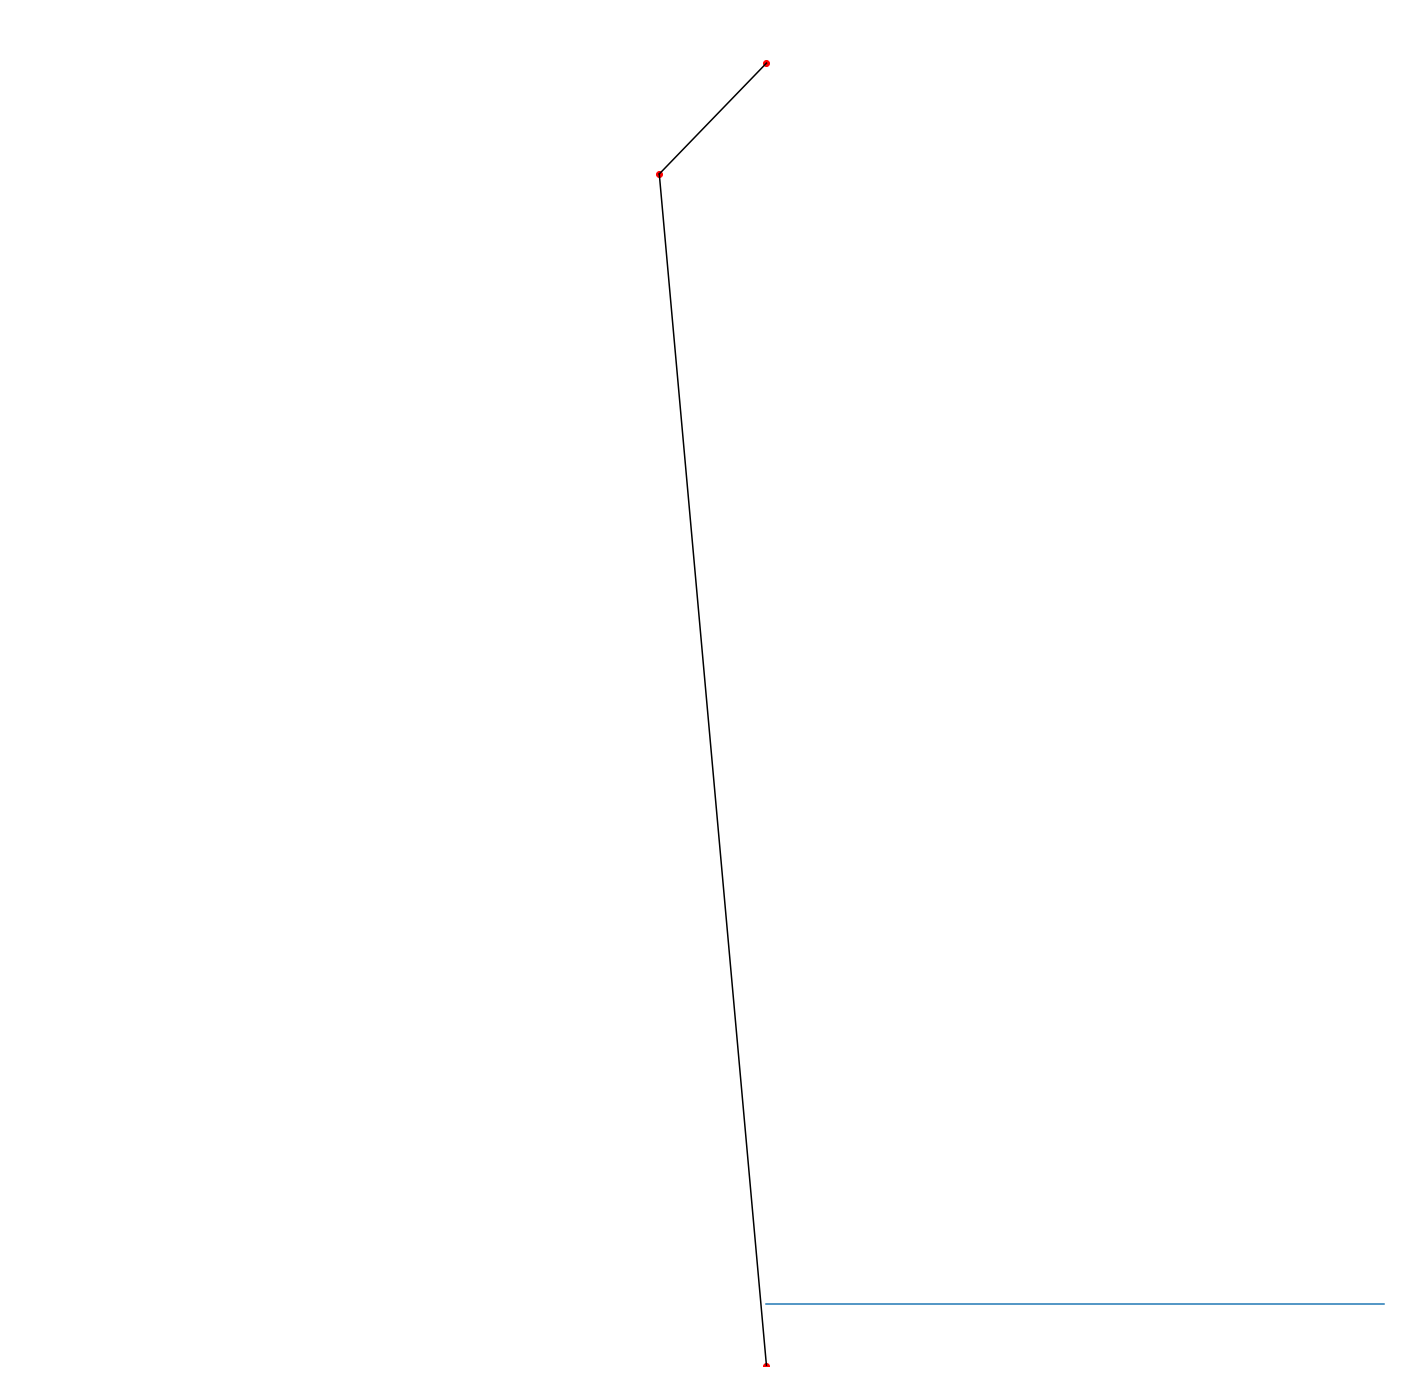

In [9]:
nImages=500
startAt=501
imageList,imageLabel,imageSupporting=generateImages(startAt,nImages+startAt)



In [10]:
dfY=pd.DataFrame(imageLabel)
dfY.to_csv('dfY501.csv')
dfImageList=pd.DataFrame(imageList)
dfImageList.to_csv('imageList501.csv')
dfImageSupporting=pd.DataFrame.from_dict(imageSupporting,orient='index')
dfImageSupporting.to_csv('ImageSupporting501.csv')



NameError: name 'imageLabel' is not defined

In [11]:
def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width,height,width*height
for i in range(0,1):
    path=r'C:\Users\aliad\Documents\Data Science\faceMe'
    fname=path+"\TFA"+str(i)+".jpg"
    print (get_num_pixels(fname))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\aliad\\Documents\\Data Science\\faceMe\\TFA0.jpg'

In [ ]:
def ext_img_feat(image_folder, batch_size):
    #base_model = ResNet50(weights='imagenet')
    #img_model = Model(input=base_model.input, output=base_model.get_layer('res5c').output)

    img_list = os.listdir(image_folder)
    all_img_feats = list()
    si = 0
    imgsL=[]
    while si < len(img_list):
        batch_img = img_list[si:si+batch_size]
        si += batch_size
        imgs = []
        for imgf in batch_img:
            img_path = os.path.join(image_folder, imgf)
            img = load_img(img_path, target_size=(2400, 2400))
            x = img_to_array(img)
            print("1: " ,np.shape(img))          
            x = np.expand_dims(x, axis=0)
            print("2: ",np.shape(x))          

            x = preprocess_input(x)
            print("3: ",np.shape(x))          

            imgs.append(x)
            print("4: ",np.shape(imgs))          

        imgsL = np.concatenate(imgs, axis=0)
        print("5: ",np.shape(imgsL))          

        #img_feats = img_model.predict(imgs)
        #all_img_feats.append(img_feats)
        print('%d images extracted\r'%si),
    return imgsL

In [ ]:
path=r'C:\Users\aliad\Documents\Data Science\femur\data\trainingImages'
batch_size=16
imgs=ext_img_feat(path, batch_size)

In [ ]:
np.shape(imgs)

In [ ]:
x=2
print("3: ",np.shape(x))          
